In [1]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
devices = preprocessing.load_device_ids()
features,y = preprocessing.load_feature_data()

In [3]:
directory = r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\rolling_data_device_'
df = pd.DataFrame()

In [4]:
for device in devices:
    temp_directory = directory + str(device) + '.h5'
    df = df.append(pd.read_hdf(temp_directory, key="df"))

In [5]:
df

doy_id  temperature            datetime  device_id  order  \
857700  48790:2019:200         24.0 2019-07-19 09:46:26      48790      0   
857701  48790:2019:200         24.2 2019-07-19 09:49:25      48790      1   
857702  48790:2019:200         23.7 2019-07-19 09:52:24      48790      2   
857703  48790:2019:200         23.3 2019-07-19 09:55:23      48790      3   
857704  48790:2019:200         23.1 2019-07-19 09:58:22      48790      4   
...                ...          ...                 ...        ...    ...   
211295   59519:2020:19          3.5 2020-01-19 18:34:41      59519   2207   
211296   59519:2020:19          3.5 2020-01-19 18:38:31      59519   2208   
211297   59519:2020:19          3.5 2020-01-19 18:41:30      59519   2209   
211298   59519:2020:19          3.5 2020-01-19 18:44:56      59519   2210   
211299   59519:2020:19          3.5 2020-01-19 18:48:32      59519   2211   

                   id  
857700    (48790, 99)  
857701    (48790, 99)  
857702    (48790, 99)  
857703    (48790, 99)  
857704    (48790, 99)  
...               ...  
211295  (59519, 2211)  
211296  (59519, 2211)  
211297  (59519, 2211)  
211298  (59519, 2211)  
211299  (59519, 2211)  

[48762200 rows x 6 columns]

In [6]:
features[features.temperature__benford_correlation == features.temperature__benford_correlation.min()]

temperature__variance_larger_than_standard_deviation  \
49589 57781                                                1.0      

             temperature__has_duplicate_max  temperature__has_duplicate_min  \
49589 57781                             0.0                             1.0   

             temperature__has_duplicate  temperature__sum_values  \
49589 57781                         1.0                    677.8   

             temperature__abs_energy  temperature__mean_abs_change  \
49589 57781                  4929.78                      0.081818   

             temperature__mean_change  \
49589 57781                  0.039394   

             temperature__mean_second_derivative_central  temperature__median  \
49589 57781                                      0.00102                  6.7   

             ...  temperature__lempel_ziv_complexity__bins_2  \
49589 57781  ...                                        0.16   

             temperature__lempel_ziv_complexity__bins_3  \
49589 57781                                        0.23   

             temperature__lempel_ziv_complexity__bins_5  \
49589 57781                                        0.28   

             temperature__lempel_ziv_complexity__bins_10  \
49589 57781                                          0.4   

             temperature__lempel_ziv_complexity__bins_100  \
49589 57781                                          0.72   

             temperature__permutation_entropy__dimension_3__tau_1  \
49589 57781                                           0.765474      

             temperature__permutation_entropy__dimension_4__tau_1  \
49589 57781                                           0.973876      

             temperature__permutation_entropy__dimension_5__tau_1  \
49589 57781                                           1.123889      

             temperature__permutation_entropy__dimension_6__tau_1  \
49589 57781                                           1.280329      

             temperature__permutation_entropy__dimension_7__tau_1  
49589 57781                                           1.417146     

[1 rows x 541 columns]

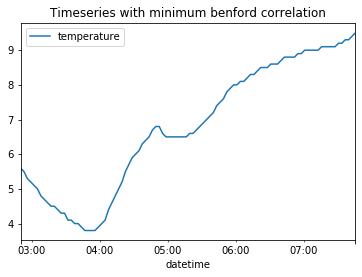

In [7]:
df[df.id == (49589,57781)].plot(x='datetime',y='temperature',title = "Timeseries with minimum benford correlation")

In [8]:
features[features.temperature__benford_correlation == features.temperature__benford_correlation.max()]

temperature__variance_larger_than_standard_deviation  \
49446 19031                                                1.0      

             temperature__has_duplicate_max  temperature__has_duplicate_min  \
49446 19031                             1.0                             0.0   

             temperature__has_duplicate  temperature__sum_values  \
49446 19031                         1.0                    128.2   

             temperature__abs_energy  temperature__mean_abs_change  \
49446 19031                   301.66                      0.185859   

             temperature__mean_change  \
49446 19031                 -0.010101   

             temperature__mean_second_derivative_central  temperature__median  \
49446 19031                                     -0.00102                  1.0   

             ...  temperature__lempel_ziv_complexity__bins_2  \
49446 19031  ...                                        0.14   

             temperature__lempel_ziv_complexity__bins_3  \
49446 19031                                        0.21   

             temperature__lempel_ziv_complexity__bins_5  \
49446 19031                                        0.31   

             temperature__lempel_ziv_complexity__bins_10  \
49446 19031                                         0.44   

             temperature__lempel_ziv_complexity__bins_100  \
49446 19031                                           0.7   

             temperature__permutation_entropy__dimension_3__tau_1  \
49446 19031                                           1.267708      

             temperature__permutation_entropy__dimension_4__tau_1  \
49446 19031                                           1.756899      

             temperature__permutation_entropy__dimension_5__tau_1  \
49446 19031                                           2.198799      

             temperature__permutation_entropy__dimension_6__tau_1  \
49446 19031                                           2.591756      

             temperature__permutation_entropy__dimension_7__tau_1  
49446 19031                                           2.858725     

[1 rows x 541 columns]

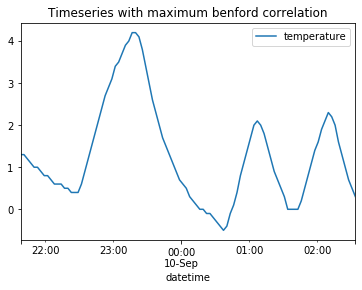

In [9]:
#Draw a shaded region from -0.2 to 2 to show benford correlation. Add histogram showing distribution of numbers starting with 1,2,3,4...
#Draw the benford correlation.
df[df.id == (49446,19031)].plot(x='datetime',y='temperature',title = "Timeseries with maximum benford correlation")

In [10]:
features[features.temperature__ar_coefficient__coeff_10__k_10 == features.temperature__ar_coefficient__coeff_10__k_10.max()]

temperature__variance_larger_than_standard_deviation  \
49486 19297                                                0.0      

             temperature__has_duplicate_max  temperature__has_duplicate_min  \
49486 19297                             1.0                             1.0   

             temperature__has_duplicate  temperature__sum_values  \
49486 19297                         1.0                    400.9   

             temperature__abs_energy  temperature__mean_abs_change  \
49486 19297                  1607.29                       0.00404   

             temperature__mean_change  \
49486 19297                       0.0   

             temperature__mean_second_derivative_central  temperature__median  \
49486 19297                                     -0.00051                  4.0   

             ...  temperature__lempel_ziv_complexity__bins_2  \
49486 19297  ...                                        0.17   

             temperature__lempel_ziv_complexity__bins_3  \
49486 19297                                        0.17   

             temperature__lempel_ziv_complexity__bins_5  \
49486 19297                                        0.17   

             temperature__lempel_ziv_complexity__bins_10  \
49486 19297                                         0.17   

             temperature__lempel_ziv_complexity__bins_100  \
49486 19297                                          0.17   

             temperature__permutation_entropy__dimension_3__tau_1  \
49486 19297                                           0.156349      

             temperature__permutation_entropy__dimension_4__tau_1  \
49486 19297                                           0.214731      

             temperature__permutation_entropy__dimension_5__tau_1  \
49486 19297                                           0.288429      

             temperature__permutation_entropy__dimension_6__tau_1  \
49486 19297                                           0.348733      

             temperature__permutation_entropy__dimension_7__tau_1  
49486 19297                                           0.409954     

[1 rows x 541 columns]

In [11]:
features[features.temperature__ar_coefficient__coeff_10__k_10 == features.temperature__ar_coefficient__coeff_10__k_10.min()]

temperature__variance_larger_than_standard_deviation  \
49486 13343                                                0.0      

             temperature__has_duplicate_max  temperature__has_duplicate_min  \
49486 13343                             1.0                             1.0   

             temperature__has_duplicate  temperature__sum_values  \
49486 13343                         1.0                    442.2   

             temperature__abs_energy  temperature__mean_abs_change  \
49486 13343                   1968.8                      0.013131   

             temperature__mean_change  \
49486 13343                  0.013131   

             temperature__mean_second_derivative_central  temperature__median  \
49486 13343                                          0.0                  4.3   

             ...  temperature__lempel_ziv_complexity__bins_2  \
49486 13343  ...                                        0.17   

             temperature__lempel_ziv_complexity__bins_3  \
49486 13343                                        0.17   

             temperature__lempel_ziv_complexity__bins_5  \
49486 13343                                        0.17   

             temperature__lempel_ziv_complexity__bins_10  \
49486 13343                                         0.18   

             temperature__lempel_ziv_complexity__bins_100  \
49486 13343                                          0.19   

             temperature__permutation_entropy__dimension_3__tau_1  \
49486 13343                                               -0.0      

             temperature__permutation_entropy__dimension_4__tau_1  \
49486 13343                                               -0.0      

             temperature__permutation_entropy__dimension_5__tau_1  \
49486 13343                                               -0.0      

             temperature__permutation_entropy__dimension_6__tau_1  \
49486 13343                                               -0.0      

             temperature__permutation_entropy__dimension_7__tau_1  
49486 13343                                               -0.0     

[1 rows x 541 columns]

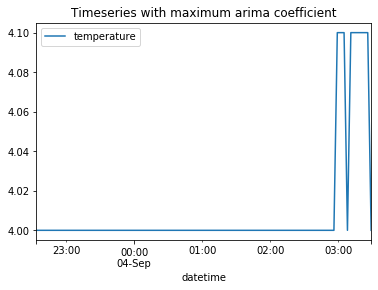

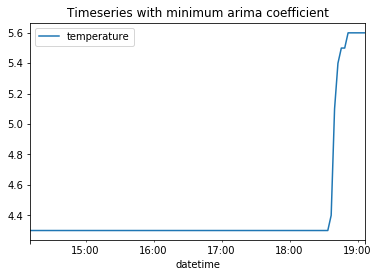

In [12]:
#dont go for max/min go for 3rd/1st quartile and median  or 90th quantile

df[df.id == (49486,19297)].plot(x='datetime',y='temperature',title = "Timeseries with maximum arima coefficient")
df[df.id == (49486,13343)].plot(x='datetime',y='temperature',title = "Timeseries with minimum arima coefficient")

In [13]:
min_idx = features[features["temperature__approximate_entropy__m_2__r_0.1"] == features["temperature__approximate_entropy__m_2__r_0.1"].min()].index[0]
max_idx = features[features["temperature__approximate_entropy__m_2__r_0.1"] == features["temperature__approximate_entropy__m_2__r_0.1"].max()].index[0]

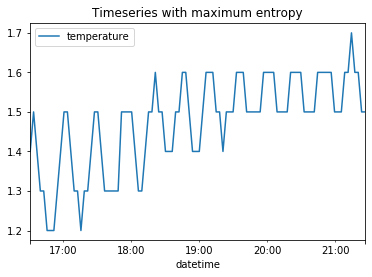

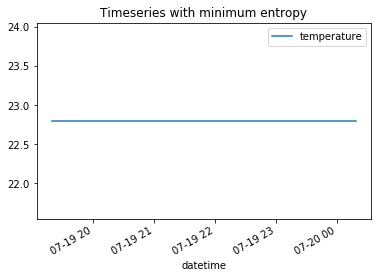

In [14]:
df[df.id == max_idx].plot(x='datetime',y='temperature',title = "Timeseries with maximum entropy")

#could not be a fridge
df[df.id == min_idx].plot(x='datetime',y='temperature',title = "Timeseries with minimum entropy")

In [15]:
df[df.id == min_idx]

doy_id  temperature            datetime  device_id  order  \
876700  48790:2019:200         22.8 2019-07-19 19:19:47      48790    190   
876701  48790:2019:200         22.8 2019-07-19 19:22:46      48790    191   
876702  48790:2019:200         22.8 2019-07-19 19:25:45      48790    192   
876703  48790:2019:200         22.8 2019-07-19 19:28:44      48790    193   
876704  48790:2019:200         22.8 2019-07-19 19:31:43      48790    194   
...                ...          ...                 ...        ...    ...   
876795  48790:2019:201         22.8 2019-07-20 00:07:08      48790    285   
876796  48790:2019:201         22.8 2019-07-20 00:10:07      48790    286   
876797  48790:2019:201         22.8 2019-07-20 00:13:06      48790    287   
876798  48790:2019:201         22.8 2019-07-20 00:16:05      48790    288   
876799  48790:2019:201         22.8 2019-07-20 00:19:04      48790    289   

                  id  
876700  (48790, 289)  
876701  (48790, 289)  
876702  (48790, 289)  
876703  (48790, 289)  
876704  (48790, 289)  
...              ...  
876795  (48790, 289)  
876796  (48790, 289)  
876797  (48790, 289)  
876798  (48790, 289)  
876799  (48790, 289)  

[100 rows x 6 columns]